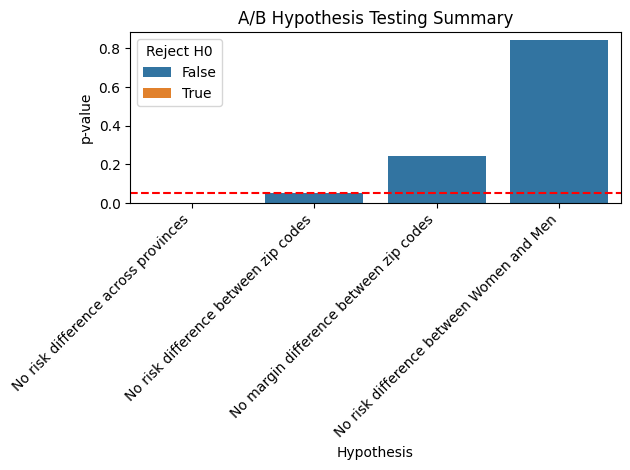

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
import os
"""
## A/B Hypothesis Testing for Insurance Risk Drivers
This notebook validates or rejects key hypotheses around risk factors using A/B statistical testing. The results will guide premium optimization and risk segmentation strategies.

### KPIs:
- **Claim Frequency**: Share of policies with >0 claims
- **Claim Severity**: Average TotalClaims for claimed policies
- **Margin**: TotalPremium - TotalClaims

### Null Hypotheses (H₀):
1. No risk differences across provinces
2. No risk differences between zip codes
3. No margin difference between zip codes
4. No risk difference between Women and Men
"""


# Load cleaned data
file_path = "../data/raw/MachineLearningRating_v3.csv"
df = pd.read_csv(file_path, sep='|', low_memory=False)

# Derive necessary columns for testing
df['HasClaim'] = df['TotalClaims'] > 0
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

"""
## 1. Province Risk Difference
We compare Claim Frequency across Gauteng and Western Cape using a two-proportion z-test.
"""
province_stats = df.groupby('Province')['HasClaim'].agg(['sum', 'count']).reset_index()
a = df[df['Province'] == 'Gauteng']['HasClaim']
b = df[df['Province'] == 'Western Cape']['HasClaim']
count = [a.sum(), b.sum()]
nobs = [a.count(), b.count()]
stat, pval_prov = proportions_ztest(count, nobs)

"""
## 2. Zip Code Risk Difference
Top two zip codes by frequency are tested for claim rate differences.
"""
top_zips = df['PostalCode'].value_counts().head(10).index.tolist()
zip_a = df[df['PostalCode'] == top_zips[0]]['HasClaim']
zip_b = df[df['PostalCode'] == top_zips[1]]['HasClaim']
count_zip = [zip_a.sum(), zip_b.sum()]
nobs_zip = [zip_a.count(), zip_b.count()]
stat_zip, pval_zip = proportions_ztest(count_zip, nobs_zip)

"""
## 3. Margin Difference by Zip Code
We perform an independent t-test on the margins across the same zip codes.
"""
margin_a = df[df['PostalCode'] == top_zips[0]]['Margin']
margin_b = df[df['PostalCode'] == top_zips[1]]['Margin']
stat_margin, pval_margin = ttest_ind(margin_a, margin_b, equal_var=False)

"""
## 4. Gender Risk Difference
Testing if claim frequency differs by gender.
"""
g_male = df[df['Gender'] == 'Male']['HasClaim']
g_female = df[df['Gender'] == 'Female']['HasClaim']
count_g = [g_male.sum(), g_female.sum()]
nobs_g = [g_male.count(), g_female.count()]
stat_gender, pval_gender = proportions_ztest(count_g, nobs_g)

"""
## 5. Summary Table
We summarize all results with p-values and hypothesis decisions.
"""
results = pd.DataFrame({
    'Hypothesis': [
        'No risk difference across provinces',
        'No risk difference between zip codes',
        'No margin difference between zip codes',
        'No risk difference between Women and Men'
    ],
    'p-value': [pval_prov, pval_zip, pval_margin, pval_gender],
    'Reject H0': [p < 0.05 for p in [pval_prov, pval_zip, pval_margin, pval_gender]]
})
# Create the outputs directory if it doesn't exist
os.makedirs("../outputs", exist_ok=True)
# Save outputs
df.to_csv("../outputs/df_with_ab_features.csv", index=False)
results.to_csv("../outputs/ab_test_summary.csv", index=False)

"""
## 6. Visualization
Barplot of p-values and decision boundary.
"""
sns.barplot(x='Hypothesis', y='p-value', hue='Reject H0', data=results)
plt.axhline(0.05, color='red', linestyle='--')
plt.title("A/B Hypothesis Testing Summary")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("../outputs/ab_testing_summary_plot.png")
plt.show()
